In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports


In [5]:

from bioreaction.simulation.manager import simulate_steady_states
from functools import partial
from typing import Optional, Tuple
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.70"

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [21]:
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.misc.type_handling import append_nest_dicts
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.srv.io.manage.script_manager import script_preamble

# Find good starting circuits


## Load data


In [7]:
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

config = load_json_as_dict(os.path.join(fn.split('summarise')[
                           0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'

## Select starting candidate

We want to start with a circuit that has high adaptability, so a circuit that has high signal sensitivity and precision. We'll use the non-signal species $RNA_1$ and $RNA_2$ as the outputs.

One thing to look out for is that because precision is often then inverse of sensitivity, it will be much larger typically, so selecting the largest for both should give preference to sensitivity.


In [32]:
signal_species = config['signal']['inputs']

filt = ((np.sum(data[get_true_interaction_cols(data, 'energies')]) != 0) & (
    data['sample_name'].isin(signal_species) != True) & (
        data['overshoot'] > 0
))

percentile = 0.96
sensitivity_range = data[filt]['sensitivity_wrt_species-6'] > (data[filt]['sensitivity_wrt_species-6'].max() *
                                                               percentile)
starting_circ_rows = data[filt][sensitivity_range].sort_values(
    by='precision_wrt_species-6', ascending=False)

print(
    f'Picking circuits that have a sensitivity of at least {data[filt]["sensitivity_wrt_species-6"].max() * percentile}')

starting_circ_rows

Picking circuits that have a sensitivity of at least 0.389391936


,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name,is_in_starting,Starting circuit
377023,toy_mRNA_circuit_10622,RNA_0_m5-9,5,"[11, 2, 0, 0, 2]","[5, 12, 1, 15, 19]",data/ensemble_mutation_effect_analysis/2023_07...,39.0,toy_mRNA_circuit_10622,[[0 1]],[[1 1]],...,0.582016,1.168085,1.168085,0.628673,inf,inf,0.679844,RNA_1,False,False
1042709,toy_mRNA_circuit_11726,RNA_0_m3-8,3,"[5, 6, 4]","[15, 9, 4]",data/ensemble_mutation_effect_analysis/2023_07...,28.0,toy_mRNA_circuit_11726,[[0 2]\n [1 2]],[],...,0.588115,0.512502,0.507635,0.287576,43.528206,inf,0.301410,RNA_2,False,True


In [33]:
starting_circ_rows[['sensitivity_wrt_species-6']]


,sensitivity_wrt_species-6
377023,0.392066
1042709,0.405617


In [26]:
((data['Starting circuit'] + 0.1)/1.1).max()

1.0

Text(0, 0.5, 'Precision')

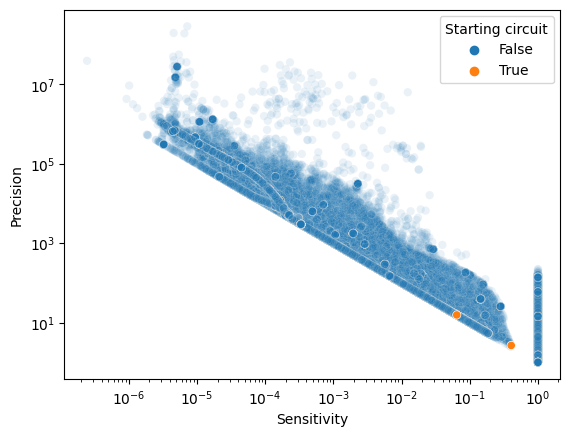

In [27]:

data['Starting circuit'] = (data['circuit_name'].isin(starting_circ_rows['circuit_name'])) & \
    (data['mutation_name'].isin(starting_circ_rows['mutation_name'])) & filt
sns.scatterplot(
    data.sort_values(by='Starting circuit'), x='sensitivity_wrt_species-6', y='precision_wrt_species-6',
    hue='Starting circuit', alpha=(data.sort_values(by='Starting circuit')['Starting circuit'] + 0.1)/1.1
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')

# Monte Carlo optimisation

We want to push circuits into ranges of higher sensitivity


## Optimisation function


In [ ]:
def optimise_

## Optimisation loop


### Initialise and set up run

In [ ]:
config, data_writer = script_preamble(config)

CircuitModeller(data_writer, config)
Evolver

### Start loop

In [ ]:


total_steps = 1000

starting = 0
for step in range(total_steps):
    
    batch = mutate(starting)
    batch = simulate(batch)
    starting = choose_next(batch)
    
    

## Visualise circuit trajectory
